In [41]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(1,
                os.path.abspath('/hetghome/antonpr/MCEq'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
import numpy as np
import mceq_config as config
from MCEq.core import MCEqRun
from MCEq.geometry.density_profiles import GeneralizedTarget
import matplotlib.pyplot as plt

In [43]:
import MCEq
MCEq.__version__

'1.4.2'

In [44]:
config.debug_level = 1
config.max_density = 0.001225
config.e_min = 1e-2
config.muon_helicity_dependence = False
config.average_loss_operator = True
config.enable_2D = False
config.mceq_db_fname = "/hetghome/antonpr/MCEq/MCEq/data/mceq_db_lext_dpm191_v150.h5"

In [45]:
target_grammage = 10000 # g/cm2
target = GeneralizedTarget(len_target=target_grammage/config.max_density, 
                           env_density=config.max_density, 
                           env_name='homogeneous air')

In [46]:
mceq = MCEqRun(interaction_model="DPMJETIII191", 
               theta_deg=None, 
               density_model=target, 
               primary_model=None,
            #    particle_list=[(13,0),(-13,0), (2212, 0)],
               )

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)


In [47]:
print(f"Target maxX={target.max_X}, target length={target.len_target/1e2:.2f} m")

Target maxX=10000.0, target length=81632.65 m


In [ ]:
emu_vec = np.logspace(-1,7,100)
dEdX_vec = []
for Emu in emu_vec:
    mceq.set_single_primary_particle(E=Emu,pdg_id=13)
    mceq.solve()
    dEdX = (np.trapz(mceq.get_solution("mu-", mag=0) * mceq.e_grid, mceq.e_grid)/np.trapz(mceq.get_solution("mu-", mag=0), mceq.e_grid) - Emu)/target.max_X
    dEdX_vec.append(-1e3*dEdX)
    print(f"<dEdX> = {dEdX*-1e3} MeV @ E_mu={Emu} GeV")

In [ ]:
# plt.loglog(mceq.e_grid, mceq.get_solution("mu-", mag=0))
# # plt.xlim(.1, 20000)
# # plt.ylim(1e-8, 2)

Text(0, 0.5, '$\\langle dE/dX \\rangle$ average energy loss (MeV)')

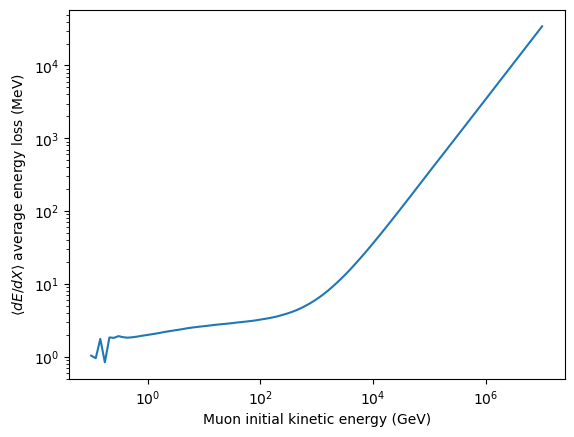

In [17]:
plt.loglog(emu_vec, dEdX_vec)
plt.xlabel("Muon initial kinetic energy (GeV)")
plt.ylabel(r"$\langle dE/dX \rangle$ average energy loss (MeV)")

In [69]:
def muon_sp(x):
    emin = 1e1
    emax = 1e4
    anorm = 1/2*(emin**(-2) - emax**(-2))
    
    if x > 1e1 and x < 1e4:
        return anorm*x**(-3)
    else:
        return 0

In [70]:
muon_sp_npfun = np.frompyfunc(lambda x: np.float64(muon_sp(x)), 1, 1)
muon_sp_grid = muon_sp_npfun(mceq._energy_grid.c).astype("float64")


In [62]:
import numpy as np
from normalized_spectrum import NormalizedSpectrum

muon_spectr = NormalizedSpectrum(pdg_id = 13,
                                 etot_min = 1, etot_max = 100, 
                                 spectral_index = 3,
                                 number_particle_norm = 1)

In [56]:
ptot_grid = np.geomspace(0.01, 1000, 100)
muon_sp_grid = muon_spectr.dNdp_tot(mceq.e_grid)

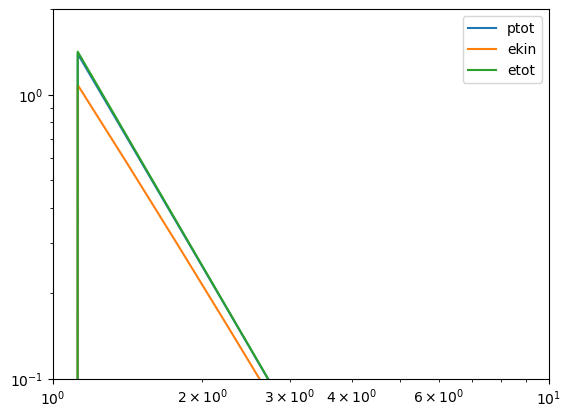

In [69]:
plt.plot(mceq.e_grid, muon_spectr.dN_dptot(mceq.e_grid), label= "ptot")
plt.plot(mceq.e_grid, muon_spectr.dN_dekin(mceq.e_grid), label= "ekin")
plt.plot(mceq.e_grid, muon_spectr.dN_detot(mceq.e_grid), label= "etot")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1, 10)
plt.ylim(0.1,2)
plt.legend()

0.001862506063757392


NameError: name 'muon_sp_grid' is not defined

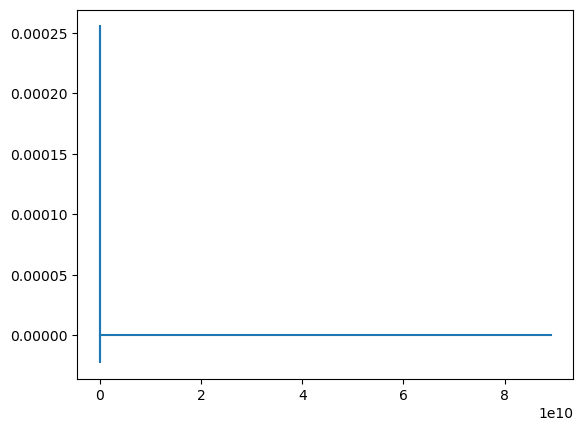

In [54]:
#mceq.set_single_primary_particle(E=1e2, pdg_id=13)

mceq.set_initial_spectrum(muon_spectr.dNdp_tot(mceq.e_grid), 
                          pdg_id=13, append=False)
# mceq._phi0 *= 0
# mceq._phi0[mceq.pman[(13, 0)].lidx : mceq.pman[(13, 0)].uidx] = muon_sp_grid

mceq.solve()
dEdX = (np.trapz(mceq.get_solution("mu-", mag=0) * mceq.e_grid, mceq.e_grid)/np.trapz(mceq.get_solution("mu-", mag=0), mceq.e_grid) - Emu)/target.max_X
print(dEdX)
plt.plot(mceq.e_grid, mceq.get_solution("mu-", mag=0)* mceq.e_grid)
plt.plot(mceq.e_grid, muon_sp_grid * mceq.e_grid)
plt.xscale("log")
plt.xlim(1e0, 1e5)
plt.yscale("log")
plt.ylim(1e-6)

(1e-10, 29601450.33009203)

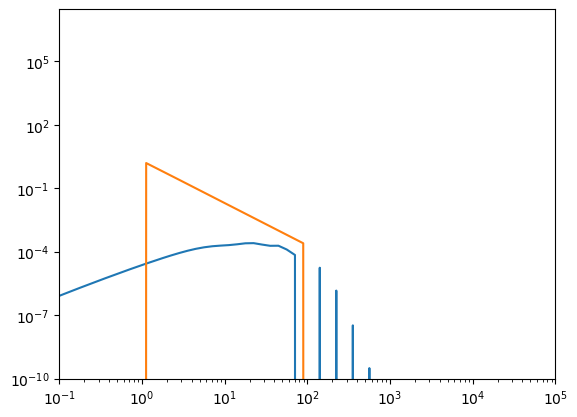

In [58]:
plt.plot(mceq.e_grid, mceq.get_solution("mu-", mag=0)* mceq.e_grid)
plt.plot(mceq.e_grid, muon_sp_grid * mceq.e_grid)
plt.xscale("log")
plt.xlim(1e-1, 1e5)
plt.yscale("log")
plt.ylim(1e-10)